In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, uniform

import pickle


from efficient_fpt.models import DDModel, weibull_survival
from efficient_fpt.utils import adaptive_interpolation
from efficient_fpt.multi_stage import get_multistage_densities

### Example 3: Ornstein-Uhlenbeck model

#### 3.1 Simulate and visualize the model

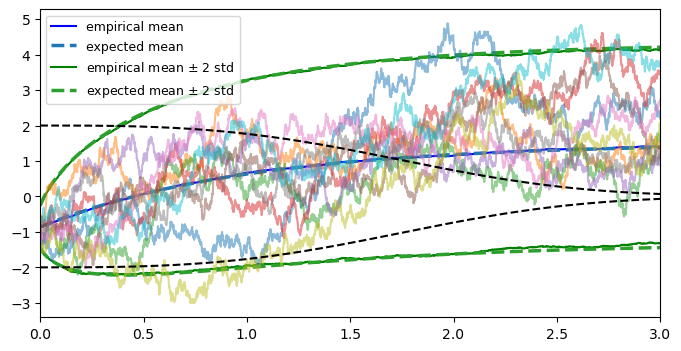

In [2]:
class OrnsteinUhlenbeckModel(DDModel):
    """
    dX(t) = theta * (mu - X(t)) * dt + sigma * dW(t)
    """

    def __init__(self, mu, theta, sigma, a, lbda, k, x0):
        super().__init__(x0)
        # drift parameters
        self.mu = mu
        self.theta = theta
        # diffusion parameter
        self.sigma = sigma
        # Weibull boundary parameters
        self.a = a
        self.lbda = lbda
        self.k = k

    def drift_coeff(self, X: float, t: float) -> float:
        return self.theta * (self.mu - X)

    def diffusion_coeff(self, X: float, t: float) -> float:
        return self.sigma

    @property
    def is_update_vectorizable(self) -> bool:
        return False

    def upper_bdy(self, t: float) -> float:
        return weibull_survival(t, self.lbda, self.k) * self.a

    def lower_bdy(self, t: float) -> float:
        return -weibull_survival(t, self.lbda, self.k) * self.a

mu = 1.5
theta = 1
sigma = 2
x0 = {"dist_name": "beta", "alpha": 10, "beta": 25}
num = 2000

a = 2
lbda = 2
k = 3
T = 3
ddm = OrnsteinUhlenbeckModel(mu=mu, theta=theta, sigma=sigma, a=a, lbda=lbda, k=k, x0=x0)
t_grid, X_grids = ddm.simulate_trajs(T=T, Nt=1000 * T, num=num)


EX0 = x0["alpha"] / (x0["alpha"] + x0["beta"]) * 2 * a - a
VarX0 = x0["alpha"] * x0["beta"] / ((x0["alpha"] + x0["beta"]) ** 2 * (x0["alpha"] + x0["beta"] + 1)) * (2 * a) ** 2
expected_mean = EX0 * np.exp(-theta * t_grid) + mu * (1 - np.exp(-theta * t_grid))
empirical_mean = np.mean(X_grids, axis=0)
expected_std = np.sqrt(VarX0 * np.exp(-2 * theta * t_grid) + sigma ** 2 / (2 * theta) * (1 - np.exp(-2 * theta * t_grid)))
empirical_std = np.std(X_grids, axis=0)


fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(t_grid, empirical_mean, label="empirical mean", c="b")
ax.plot(t_grid, expected_mean, label="expected mean", linewidth=2.5, linestyle="--", c="tab:blue")
ax.plot(t_grid, empirical_mean + 2 * empirical_std, label=r"empirical mean $\pm$ 2 std", c="g")
ax.plot(t_grid, empirical_mean - 2 * empirical_std, c="g")
ax.plot(t_grid, expected_mean + 2 * expected_std, label=r"expected mean $\pm$ 2 std", linewidth=2.5, linestyle="--", c="tab:green")
ax.plot(t_grid, expected_mean - 2 * expected_std, linewidth=2.5, linestyle="--", c="tab:green")
ax.plot(t_grid, X_grids[:10, :].T, alpha=0.5)
ax.plot(t_grid, ddm.upper_bdy(t_grid), c='k', linestyle="--")
ax.plot(t_grid, ddm.lower_bdy(t_grid), c='k', linestyle="--")
ax.autoscale(axis="x", tight=True)
ax.legend(fontsize=9)
plt.show()

#### 3.2 Simulate first passage times, compute FPTDs and NPDs

##### 3.2.1 For a small $T$, plot both FPTDs and NPD

In [3]:
T = 1
num_fpt = 50000

fp_times, np_poss = ddm.simulate_fptd_tillT(T=T, dt=0.001, num=num_fpt)
counts_t, bins_t = np.histogram(fp_times, bins=100)
dt_bin = bins_t[1] - bins_t[0]
counts_x, bins_x = np.histogram(np_poss, bins=50)
dx_bin = bins_x[1] - bins_x[0]

In [4]:
gamma = lambda t: (np.exp(2 * theta * t) - 1) / (2 * theta)
gamma_inv = lambda s: np.log(1 + 2 * theta * s) / (2 * theta)
gamma_t = lambda t: np.exp(2 * theta * t)
psi = lambda x, t: 1 / sigma * (np.exp(theta * t) * x - mu * np.exp(theta * t) + mu)
psi_inv = lambda w, t: sigma * np.exp(-theta * t) * w + mu - mu * np.exp(-theta * t)
psi_x = lambda x, t: 1 / sigma * np.exp(theta * t)

u_tilde = lambda s: psi(ddm.upper_bdy(gamma_inv(s)), gamma_inv(s))
l_tilde = lambda s: psi(ddm.lower_bdy(gamma_inv(s)), gamma_inv(s))


X0_pdf = lambda x: beta.pdf((sigma * x + a) / (2 * a), x0["alpha"], x0["beta"]) * sigma / (2 * a)

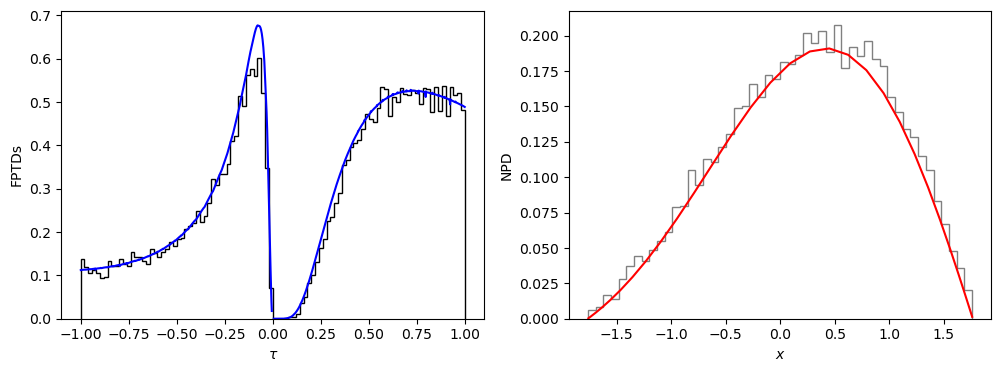

In [5]:

T_tilde = gamma(T)

s_intp_array, _ = adaptive_interpolation(l_tilde, [0, T_tilde], 0.001)
b1_array = (u_tilde(s_intp_array)[1:] - u_tilde(s_intp_array)[:-1]) / (s_intp_array[1:] - s_intp_array[:-1])
b2_array = (l_tilde(s_intp_array)[1:] - l_tilde(s_intp_array)[:-1]) / (s_intp_array[1:] - s_intp_array[:-1])
a1 = u_tilde(0)
a2 = l_tilde(0)
mu_array = np.zeros_like(b1_array)
sigma_array = np.ones_like(b1_array)
sacc_array = s_intp_array[:-1]


eps = 5e-3
ts = np.linspace(0, T, 1000)
ss = gamma(ts)
fptds, npds = get_multistage_densities(ss, mu_array, sacc_array, sigma_array, a1, b1_array, a2, b2_array, T_tilde, x0=X0_pdf, eps=eps)

ss, upper_fptds, lower_fptds = fptds[0, :], fptds[1, :], fptds[2, :]
ts = gamma_inv(ss)
upper_fptds = upper_fptds * gamma_t(ts)
lower_fptds = lower_fptds * gamma_t(ts)
xs_tilde, npd = npds[0, :], npds[1, :]
xs = psi_inv(xs_tilde, T)
npd = npd * psi_x(xs, T)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].stairs(counts_t / num_fpt / dt_bin, bins_t, color="black")
ax[0].plot(ts, upper_fptds, c='b')
ax[0].plot(-ts, lower_fptds, c='b')
ax[0].set_xlabel(r"$\tau$")
ax[0].set_ylabel("FPTDs")

ax[1].stairs(counts_x / num_fpt / dx_bin, bins_x, color="gray")
ax[1].plot(xs, npd, c='r')
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel("NPD")

plt.show()

##### 3.2.2 For a large $T$, plot the whole FPTDs

In [6]:
T = 3

# num_fpt = 100000
# dt = 1e-6
# fp_times, np_poss = ddm.simulate_fptd_tillT(T=T, dt=dt, num=num_fpt)
# data_to_save = {"fp_times": fp_times, "np_poss": np_poss,
#                 "mu": mu, "theta": theta, "sigma": sigma, "a": a, "lbda": lbda, "k": k, "T": T, "x0": x0, "num_fpt": num_fpt, "dt": dt}
# fname = "ex3_fpt_data_" + time.strftime("%Y%m%d-%H%M%S") + ".pkl"
# with open(fname, "wb") as f:
#     pickle.dump(data_to_save, f)

fpt_data = pickle.load(open("ex3_fpt_data_20250306-155720.pkl", "rb"))
fp_times = fpt_data["fp_times"]
num_fpt = fpt_data["num_fpt"]

counts_t, bins_t = np.histogram(fp_times, bins=100)
dt_bin = bins_t[1] - bins_t[0]

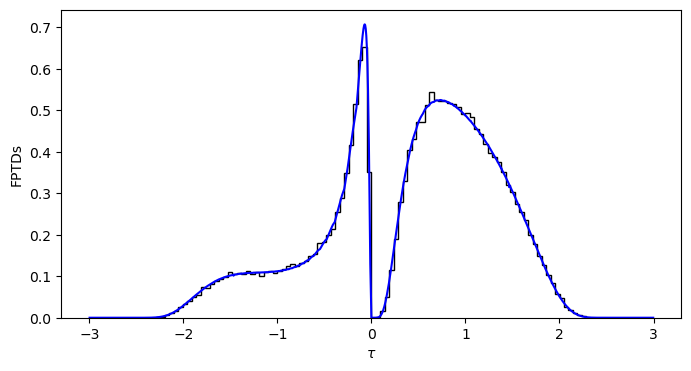

In [7]:
T_tilde = gamma(T)

s_intp_array, _ = adaptive_interpolation(l_tilde, [0, T_tilde], 0.001)
b1_array = (u_tilde(s_intp_array)[1:] - u_tilde(s_intp_array)[:-1]) / (s_intp_array[1:] - s_intp_array[:-1])
b2_array = (l_tilde(s_intp_array)[1:] - l_tilde(s_intp_array)[:-1]) / (s_intp_array[1:] - s_intp_array[:-1])
a1 = u_tilde(0)
a2 = l_tilde(0)
mu_array = np.zeros_like(b1_array)
sigma_array = np.ones_like(b1_array)
sacc_array = s_intp_array[:-1]

eps = 1e-2
ts = np.linspace(0, T, 1000)
ss = gamma(ts)
fptds, npds = get_multistage_densities(ss, mu_array, sacc_array, sigma_array, a1, b1_array, a2, b2_array, T_tilde, x0=X0_pdf, eps=eps)

ss, upper_fptds, lower_fptds = fptds[0, :], fptds[1, :], fptds[2, :]
ts = gamma_inv(ss)
upper_fptds = upper_fptds * gamma_t(ts)
lower_fptds = lower_fptds * gamma_t(ts)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.stairs(counts_t / num_fpt / dt_bin, bins_t, color="black")
ax.plot(ts, upper_fptds, c='b')
ax.plot(np.insert(-ts, 0, 0), np.insert(lower_fptds, 0, 0), c='b')
ax.set_xlabel(r"$\tau$")
ax.set_ylabel("FPTDs")

plt.show()

make plot for the paper

In [8]:
import matplotlib as mpl

import os
if '/oscar/home/sliu167/texlive/2024/bin/x86_64-linux' not in os.environ['PATH']:
    os.environ['PATH'] = '/oscar/home/sliu167/texlive/2024/bin/x86_64-linux:' + os.environ['PATH']

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amsfonts}'

from scipy.integrate import cumulative_trapezoid
from scipy.stats import ks_1samp, ecdf


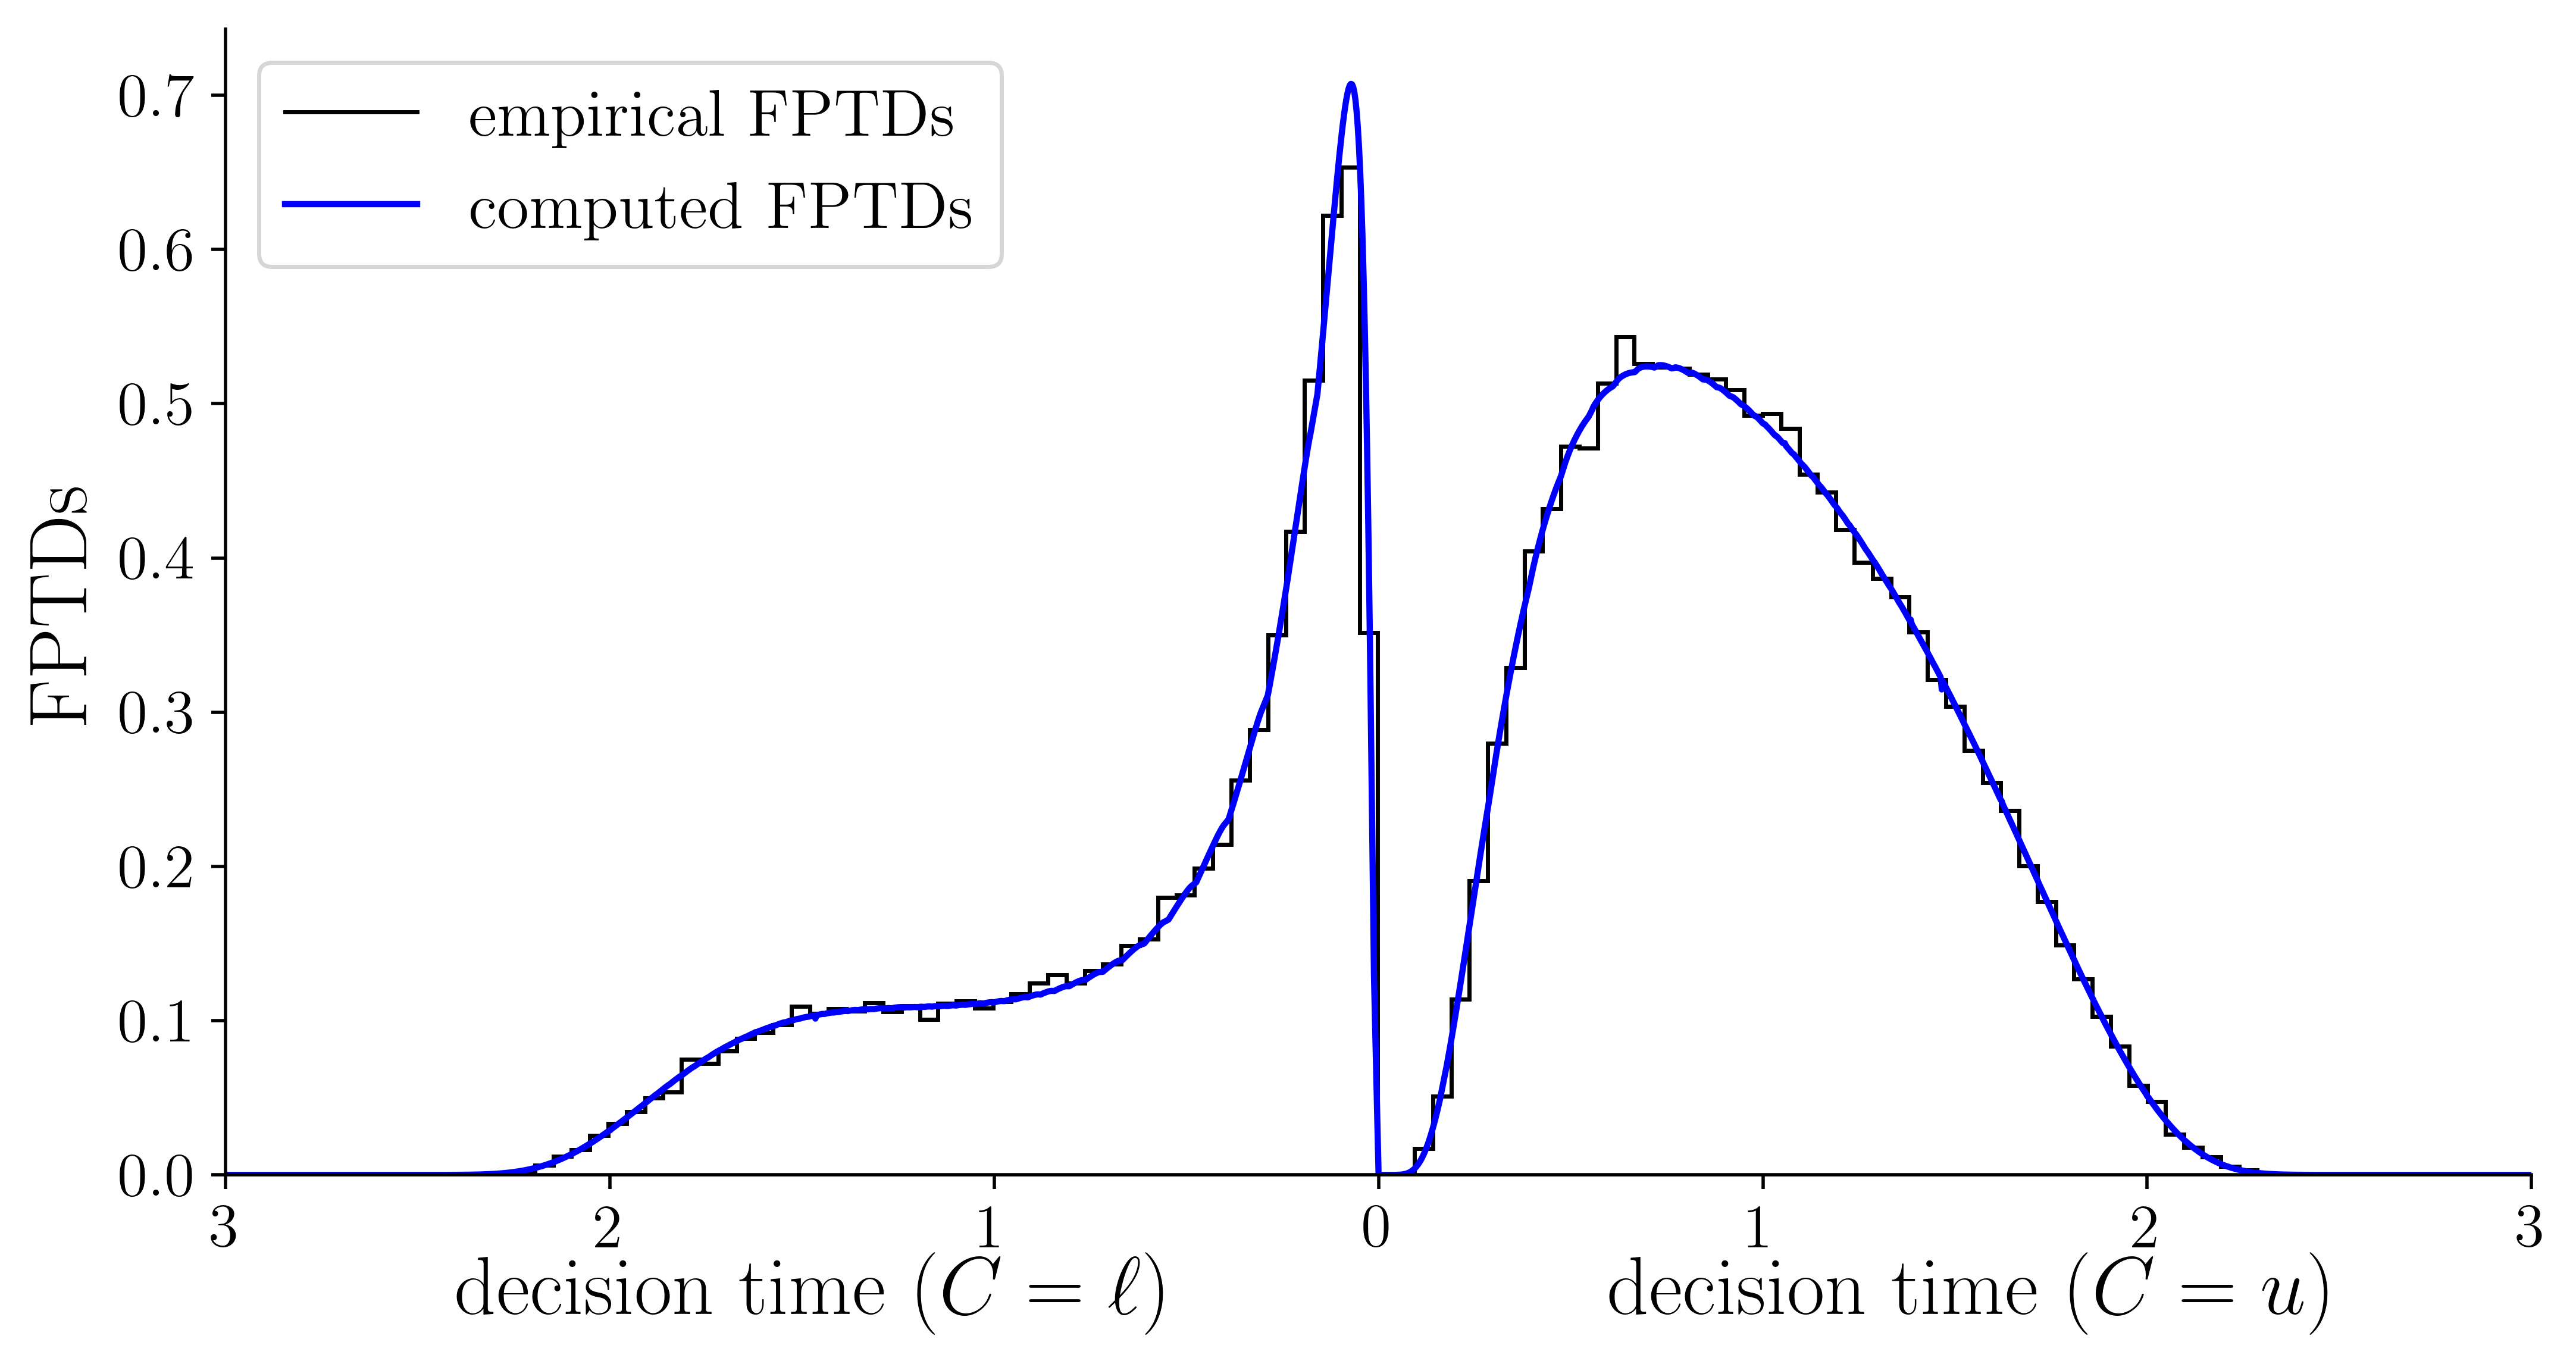

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=500)
ax.stairs(counts_t / num_fpt / dt_bin, bins_t, color="black", label="empirical FPTDs")
ax.plot(ts, upper_fptds, c='b', label="computed FPTDs")
ax.plot(np.insert(-ts, 0, 0), np.insert(lower_fptds, 0, 0), c='b')
ax.legend(fontsize=16, loc="upper left")

ax.text(-2.4, -0.09, r"decision time ($C=\ell$)", fontsize=20)
ax.text(0.6, -0.09, r"decision time ($C=u$)", fontsize=20)
ax.set_ylabel("FPTDs", fontsize=20)

ax.autoscale(tight=True, axis="x")

ax.set_xticks(np.arange(-3, 4, 1))
ax.set_xticklabels(np.hstack([np.arange(3, 0, -1), np.arange(0, 4, 1)]), fontsize=15)
yticks = np.arange(0, 0.8, 0.1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y:.1f}" for y in yticks], fontsize=15)
ax.spines[['right', 'top']].set_visible(False)


plt.savefig('ex3-figure.png', format='png', bbox_inches='tight', transparent=True)
plt.show()

In [10]:
ts_all = np.hstack((-ts[::-1], [0], ts))
fptd_all = np.hstack((lower_fptds[::-1], [0], upper_fptds))

cdf = cumulative_trapezoid(fptd_all, ts_all, initial=0)
cdf_func = lambda x: np.interp(x, ts_all, cdf)
ecdf_result = ecdf(fp_times)
# plt.plot(ts_all, cdf, c='b', label='CDF')
# plt.plot(ts_all, ecdf_result.cdf.evaluate(ts_all), c='r', label='CDF interp')
# plt.show()

for num_data in [10000, 20000, 50000, 100000]:
    pvalue = ks_1samp(fp_times[: num_data], cdf_func, method="exact").pvalue
    print(f"#data = {num_data}, p-value = {pvalue}")

#data = 10000, p-value = 0.44910243121905424
#data = 20000, p-value = 0.47313088938590653
#data = 50000, p-value = 0.1793197951948925
#data = 100000, p-value = 0.35696125225295305
